In [1]:
import os
import random
import math
import kornia
import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(109, 134)
val_labeled_scene_index = np.arange(106, 109)
test_labeled_scene_index = np.arange(106, 109)

from helper import compute_ats_bounding_boxes, compute_ts_road_map
from utils.angles import within_angles

In [2]:
VERT_BLOCK_SIZE = 10
HORIZ_BLOCK_SIZE = 10
BLOCK_AREA = VERT_BLOCK_SIZE * HORIZ_BLOCK_SIZE

In [3]:
def blur(img):
    img = img.unsqueeze(0)
    blurred = kornia.filters.gaussian_blur2d(img, kernel_size=(5, 5), sigma=(9.5, 9.5))
    return blurred.squeeze(0)

In [4]:
def collate_fn(batch):
    left_images = []
    target = []
    road_maps = []
    bbox_maps = []
    bbox_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2]).float()
        road_maps.append(road_image)
        
        # Collect front-left image.  
        # Try cutting off the top 130 pixels (that can lead to overfitting)
        image = torch.Tensor(x[0][2])[:, 120:, :]
        left_images.append(image)
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bbox_map = torch.zeros((800, 800))
        counts = np.zeros(60)
        count = 0
        
        # Create the bounding box map. 
        for i, corners in enumerate(bb_tens):
            
            # Grab the current bounding box. 
            current_bbs.append(corners)
            
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # xs is horizontal, ys is vertical through. 
            # But we're doing things row, column way. 
            
            # Only get the bounding boxes that are close-by. On the same road. 
            # We want to see if the model can fucking predict cars that are close by. 
            
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            if within_angles(xs, ys, angle1=31, angle2=90) and center_y > 255 and center_y < 500:
            
                # Grab the top-left coordinates. 
                r, c = int(torch.min(ys).item()), int(torch.min(xs).item())
                r_len, c_len = int(torch.max(ys).item()) - r, int(torch.max(xs).item()) - c

                # Fill in the bbox. 
                bbox_map[r:r+r_len, c:c+c_len] = 1.0

                count += 1
            
        # Convert the bounding box map into classes (5px by 5px bins)
        bbox_grid = []
        for x_ in range(0, 800, VERT_BLOCK_SIZE):
            for y in range(0, 800, HORIZ_BLOCK_SIZE):
                block = bbox_map[x_:x_+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as bbox car
                if score > 0.5 * (BLOCK_AREA):
                    bbox_grid.append(1.0)
                else:
                    bbox_grid.append(0.0)
                    
        bbox_bins.append(torch.Tensor(bbox_grid))
              
        counts[count] = 1

        # Label Smoothing #
#         if count > 15 and count < 88:
#             counts[count+1] = 0.2
#             counts[count-1] = 0.2
            
        target_counts.append(torch.Tensor(counts))
        
        bbox_maps.append(bbox_map)

        bbs.append(current_bbs)
                
    boom = torch.stack(left_images), torch.stack(bbox_bins), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(bbox_maps) 
    return boom

In [5]:
val_transform = transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
    transforms.RandomApply([
        transforms.Grayscale(3),
#         transforms.RandomAffine(1),
    ]),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.Lambda(lambda img: blur(img)),
    ])
])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

#### Testing

In [32]:
train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [33]:
# Compute threat scores
def reconstruct_from_bins(bins, threshold):
    print(bins.shape)
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, VERT_BLOCK_SIZE):
        for y in range(0, 800, HORIZ_BLOCK_SIZE):
            road_map[x:x+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE] = bins[idx]
            idx += 1
    return road_map > threshold

In [80]:
sample, bbox_bins, road_maps, bbs, counts, bbox_maps  = iter(train_loader).next()

In [81]:
idx = -1

In [112]:
idx += 1

tensor(1)


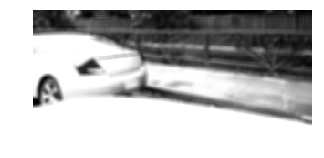

In [113]:
print(torch.argmax(counts[idx]))
matplotlib.rcParams['figure.figsize'] = [5,5]
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))
plt.axis('off');

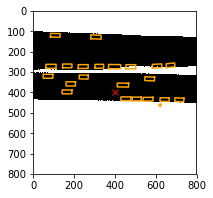

In [114]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]
fig, ax = plt.subplots()
ax.imshow(road_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bbs[idx]:
    draw_box(ax, bb, 'orange')

torch.Size([6400])


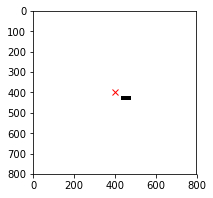

In [115]:
threshold = 0.5
road_map = reconstruct_from_bins(bbox_bins[idx], threshold)
fig, ax = plt.subplots()
ax.imshow(road_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")

### Model

In [6]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 100
        self.dropout = nn.Dropout(p = 0.2)
        self.bn = nn.BatchNorm1d(self.concat_dim)
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(512, 100)),
            ('relu', nn.ReLU()),
        ]))
        
        self.vehicle_map = nn.Sequential(OrderedDict([
            ('linear1_vehicle', nn.Linear(self.concat_dim, 6400)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 60))
        ]))
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        channels = x.shape[1]
        height = x.shape[2]
        width = x.shape[3]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        x = self.bn(x)
        x = self.dropout(x)
    
        return self.vehicle_map(x), self.counts(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model.load_state_dict(torch.load('/scratch/vr1059/front_right_image_resnet18_val_new.pt'))
model = model.to(device)
map_criterion = nn.BCEWithLogitsLoss()
count_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_val_loss = 100

In [8]:
def train():
    model.train()
    labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
    train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, num_workers=15, shuffle=True, collate_fn=collate_fn)
    
    train_losses = []
    map_losses = []
    count_losses = []
    f = open(log_file_path, "a+")
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(train_loader):
        optimizer.zero_grad()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)
        
        y_vehicle, y_count = model(sample)
        
        map_loss = map_criterion(y_vehicle, bbox_bins.float())
        count_loss = count_criterion(y_count, target_count.float())
        loss = 0.99 * map_loss + 0.01 * count_loss
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        map_losses.append(map_loss.item())
        count_losses.append(count_loss.item())
        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                50. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    print("Average Train Map Loss: ", np.mean(map_losses))
    print("Average Train Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Train Epoch Loss: {}".format(np.mean(train_losses)))
    f.write("Average Train Map Loss: {}".format(np.mean(map_losses)))
    f.write("Average Train Count Epoch Loss: {}".format(np.mean(count_losses)))
    
    f.close()
    
            
def val():
    
    val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=15, num_workers=5, shuffle=True, collate_fn=collate_fn)
    model.eval()
    val_losses = []
    map_losses = []
    count_losses = []
    
    f = open(log_file_path, "a+")
    
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)

        with torch.no_grad():
            y_vehicle, y_count = model(sample)
        
            map_loss = map_criterion(y_vehicle, bbox_bins.float())
            count_loss = count_criterion(y_count, target_count.float())
            loss = 0.99 * map_loss + 0.01 * count_loss
            
            val_losses.append(loss.item())
            map_losses.append(map_loss.item())
            count_losses.append(count_loss.item())
            
    print("\tAverage Validation Epoch Loss: ", np.mean(val_losses))
    print("\tAverage Validation Map Epoch Loss: ", np.mean(map_losses))
    print("\tAverage Validation Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Validation Epoch Loss: {}".format(np.mean(val_losses)))
    f.write("\tAverage Validation Map Epoch Loss: {}".format(np.mean(map_losses)))
    f.write("\tAverage Validation Count Epoch Loss: {}".format(np.mean(count_losses)))

    global best_val_loss
    if np.mean(map_losses) < best_val_loss:
        best_val_loss = np.mean(map_losses)
        f.write("\n best_val_loss so far: {}".format(best_val_loss))
        torch.save(model.state_dict(), '/scratch/vr1059/front_right_image_resnet18_val_new.pt')
        
    f.close()

In [9]:
log_file_path = "front_right_image_resnet_18_val_new.log"

In [10]:
epochs = 25
for epoch in range(epochs):
    train()
    val()

Train Epoch: 0 [0/3150 (0%)]	Loss: 0.001081
Train Epoch: 0 [750/3150 (12%)]	Loss: 0.002363
Train Epoch: 0 [1500/3150 (24%)]	Loss: 0.002027
Train Epoch: 0 [2250/3150 (36%)]	Loss: 0.002016
Train Epoch: 0 [3000/3150 (48%)]	Loss: 0.003863

Average Train Epoch Loss:  0.002687736525244656
Average Train Map Loss:  0.0025047742783845892
Average Train Count Epoch Loss:  0.020800997352316265
	Average Validation Epoch Loss:  0.0025770901747119543
	Average Validation Map Epoch Loss:  0.0023583724508241108
	Average Validation Count Epoch Loss:  0.024230144273203153
Train Epoch: 1 [0/3150 (0%)]	Loss: 0.003190
Train Epoch: 1 [750/3150 (12%)]	Loss: 0.002478
Train Epoch: 1 [1500/3150 (24%)]	Loss: 0.001494
Train Epoch: 1 [2250/3150 (36%)]	Loss: 0.003081
Train Epoch: 1 [3000/3150 (48%)]	Loss: 0.001730

Average Train Epoch Loss:  0.0025757823181005992
Average Train Map Loss:  0.0023897574163995504
Average Train Count Epoch Loss:  0.020992245259029523
	Average Validation Epoch Loss:  0.00271514283779722
	A

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/vr1059/py3.6.3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9977b8b33032>", line 4, in <module>
    val()
  File "<ipython-input-8-256a502ed827>", line 60, in val
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(val_loader):
  File "/home/vr1059/py3.6.3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 345, in __next__
    data = self._next_data()
  File "/home/vr1059/py3.6.3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 841, in _next_data
    idx, data = self._get_data()
  File "/home/vr1059/py3.6.3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 808, in _get_data
    success, data = self._try_get_data()
  File "/home/vr1059/py3.6.3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 761, in _try_get_data
    data = self._d

KeyboardInterrupt: 

In [60]:
# Nearby cars BUT also included cars on other road, lane closest to us. 
# If performance isn't as good, I'm just going to say fuck it. 
# And only focus on cars on the same road to us. 